In [1]:
import sys
import os
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import cooler
from sklearn.decomposition import PCA
import glob
import pyBigWig

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

# local imports
source_path = os.path.abspath("../../source/")
sys.path.append(source_path)
import utils as ut
import plotting as plt2
import hypercore as hc
import matrix as matrix
import centrality as central

# hyperlocal imports
import core_utils

# Get chromsizes

In [2]:
reload(core_utils)
# load chromsizes 
fpath = "/scratch/indikar_root/indikar1/shared_data/population/references/GRCm39.chrom.sizes"
chroms, chrom_starts = core_utils.load_chrom_sizes(fpath)
chroms.head()

,chrom,size,bp_start
0,1,195154279,0
1,2,181755017,195154279
2,3,159745316,376909296
3,4,156860686,536654612
4,5,151758149,693515298


# Load population pore-c

In [3]:
reload(core_utils)
    
dpath = "/scratch/indikar_root/indikar1/shared_data/population/align_table/"
file_list = glob.glob(f"{dpath}*")
resolution = 1e6
chromosomes = ['2']
df = core_utils.load_pore_c(
    file_list, 
    chrom_starts, 
    resolution=resolution,
    chroms=chromosomes
)
print(f"{df.shape=}")
df['ones'] = 1
df.head()

batch04 (177353, 8)
batch02 (18558, 8)
batch03 (92905, 8)
batch01 (162436, 8)
df.shape=(451252, 8)


,read_name,align_id,order,chrom,local_position,global_bin,local_bin,basename,ones
264,0003227f-dfb9-4d87-85f9-db8f860f47dd,8036161,2,2,98497512.0,294,99,batch04,1
272,0003227f-dfb9-4d87-85f9-db8f860f47dd,8036169,2,2,34287050.0,230,35,batch04,1
283,000333f9-5e77-4813-912d-faf4123b1631,1539627,2,2,128099396.0,324,129,batch04,1
286,000333f9-5e77-4813-912d-faf4123b1631,1539630,2,2,134768640.0,330,135,batch04,1
323,000378e6-d6eb-498c-b717-aedcaa5c3257,817274,4,2,53060104.0,249,54,batch04,1


In [4]:
H = ut.incidence_by_pivot(
    df, 
    index='read_name',
    columns='local_bin',
    values='ones',
)
print(f"Total: {H.shape=}")
H = H.T.drop_duplicates().T
print(f"Unique: {H.shape=}")
H.head()

Total: H.shape=(179, 186255)
Unique: H.shape=(179, 53888)


read_name,00005e8d-30b2-4c05-b193-5f954681d44e,0000803f-34e7-43c4-bcd9-beea8925c4c0,00012f2d-c107-4d01-b41b-68d537917d7c,00023d22-f6bc-4012-b148-c983a910ddf9,0002a895-1877-4f69-8ded-c15568d64e8a,0002e105-2bde-491a-8d43-53d8d91ca99f,00031758-8c53-4ec6-8219-b9dfaa01bf67,00031c17-503f-4c17-a459-1a88f59278a8,0003227f-dfb9-4d87-85f9-db8f860f47dd,000333f9-5e77-4813-912d-faf4123b1631,...,ffef4414-ca17-41fa-a10c-ca0e9713e58d,fff1209b-7169-4d92-9b54-51370a1d2c2b,fff40cb0-1890-4f36-a1ac-63a05eb92fe8,fff8dc51-afc0-445d-bfe4-c692410915c2,fff97148-f68f-4469-a728-0abd65f751bb,fffbb892-66d2-4ee6-bdeb-f7d854d75b35,fffc0ee8-4407-4a43-b527-b3237ba2e9d8,fffc84e9-9d73-470e-85c4-679049a68baf,fffed480-36e9-42b6-b3c6-27dc516e6a34,fffef91a-27b8-466a-a913-61292d2d5efe
local_bin,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'outlier_indices=[99]'
A.shape=(178, 178)


Text(0.5, 302.6666666666665, '')

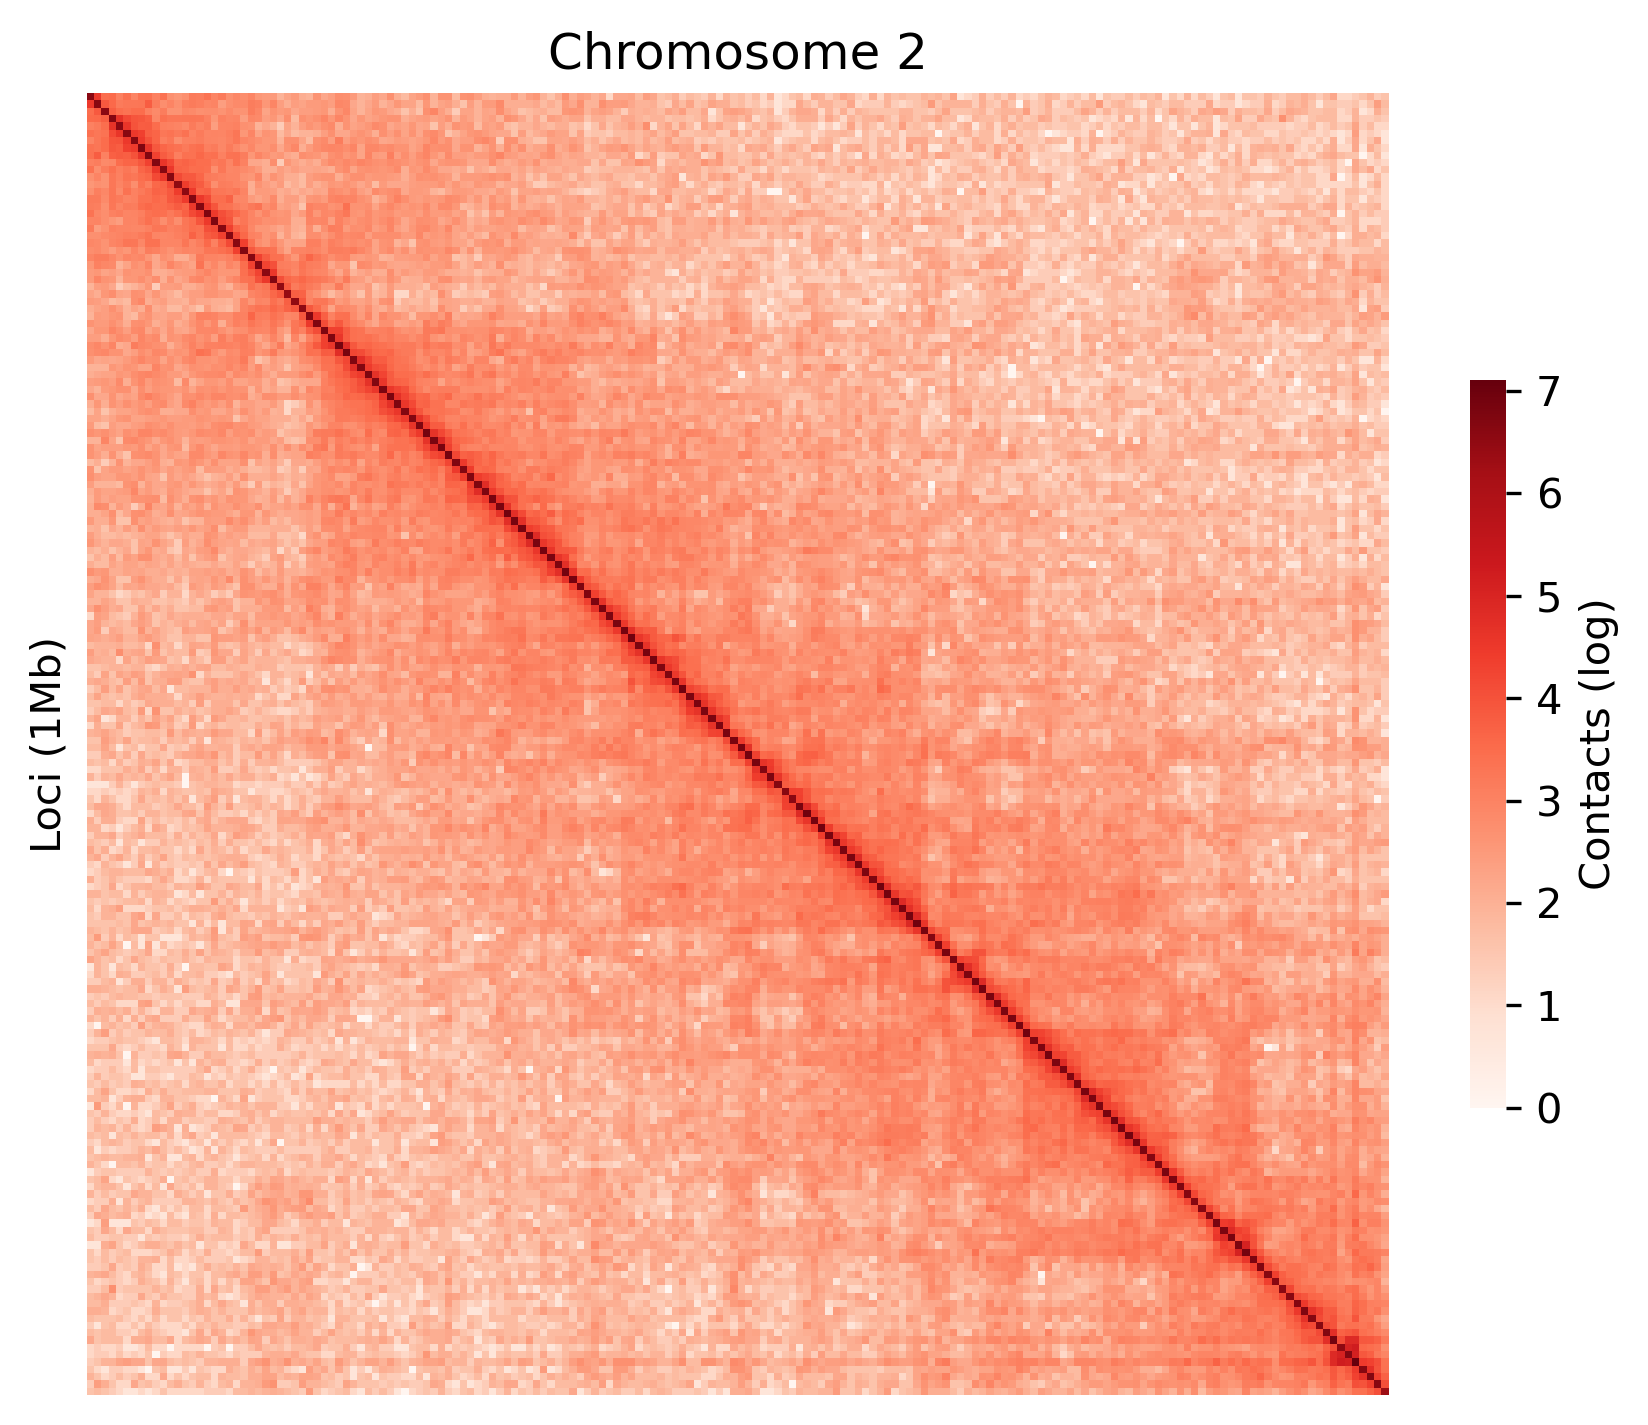

In [5]:
A = matrix.clique_expand_incidence(H, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(A, threshold=1.5)
print(f"'{outlier_indices=}'")

# drop outliers
A = A.drop(outlier_indices, axis=1)
A = A.drop(outlier_indices, axis=0)

print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(np.log1p(A), 
            cmap='Reds',
            square=True, 
            cbar_kws={'shrink' : 0.45, 'label' : 'Contacts (log)'},
           )

plt.yticks([])
plt.xticks([])

plt.title(f"Chromosome {chromosomes[0]}")
plt.ylabel(f"Loci (1Mb)")
plt.xlabel("")

# Centrality

nodes.shape=(178, 5)
len(core_nodes)=45


,local_bin,node_centrality,zscores,node_centrality_norm,core,bin_number
173,178,0.005662,1.877631,1.000000,True,178.0
2,6,0.005647,1.253244,0.951422,True,6.0
90,94,0.005643,1.068247,0.937029,True,94.0
46,50,0.005642,1.031550,0.934174,True,50.0
66,70,0.005642,1.030956,0.934128,True,70.0
32,36,0.005642,1.011627,0.932624,True,36.0
17,21,0.005641,0.980541,0.930206,True,21.0
67,71,0.005641,0.975885,0.929844,True,71.0
74,78,0.005640,0.951807,0.927970,True,78.0
108,113,0.005640,0.948844,0.927740,True,113.0


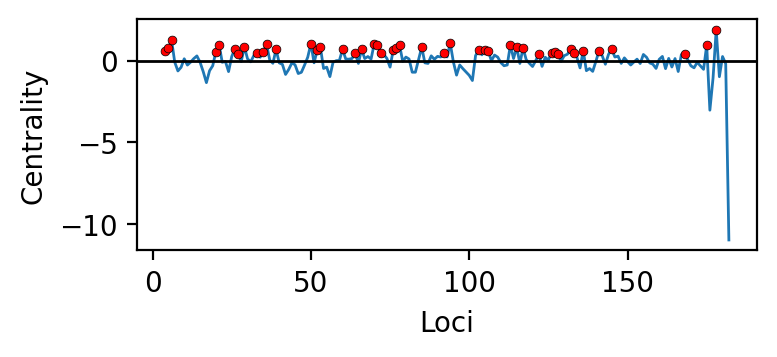

In [6]:
def get_core(H, outlier_indices, function='log-exp', q=0.75, maxiter=10000):
    """
    Calculates nonlinear eigenvector centrality and related metrics.

    Args:
        H: The adjacency matrix (pandas DataFrame).
        outlier_indices: List of indices to drop from H.
        function: Nonlinear function for centrality calculation (default: 'log-exp').
        q: Quantile threshold for defining 'core' nodes (default: 0.75).
        maxiter: Maximum iterations for centrality calculation.

    Returns:
        pandas.DataFrame: A DataFrame with node information and centrality metrics.
    """
    
    # Remove outliers and zero-sum columns (without explicit checks)
    Hhat = H.drop(outlier_indices).loc[:, (H.sum(axis=0) != 0)]

    # Calculate centrality using NetworkX
    nodes_cent, _ = central.nonlinear_eigenvector_centrality(
        Hhat, 
        function=function, 
        maxiter=maxiter,
    )

    # Create DataFrame with results
    nodes = pd.DataFrame({
        'local_bin': Hhat.index,
        'node_centrality': nodes_cent,
        'zscores': stats.zscore(nodes_cent),
        'node_centrality_norm': ut.min_max(nodes_cent),  # Assuming you have ut.min_max elsewhere
        'core' : nodes_cent >= np.quantile(nodes_cent, q),
    })

    return nodes


nodes = get_core(H, outlier_indices)
print(f"{nodes.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 1.5

sns.lineplot(
    data=nodes,
    x='local_bin',
    y='zscores',
    lw=1,
)

sns.scatterplot(
    data=nodes[nodes['core']],
    x='local_bin',
    y='zscores',
    s=10,
    c='r',
    ec='k', 
    zorder=5,
)

plt.axhline(y=0, lw=1, c='k')

plt.ylabel('Centrality')
plt.xlabel('Loci')

core_nodes = sorted(nodes[nodes['core']]['local_bin'].values)
print(f"{len(core_nodes)=}")

nodes = nodes.sort_values(by='zscores', ascending=False)
nodes['bin_number'] = nodes['local_bin'].astype(float)

nodes.head(10)

In [7]:
nodes['core'].sum()

45

threshold=0.3891188221208042


([], [])

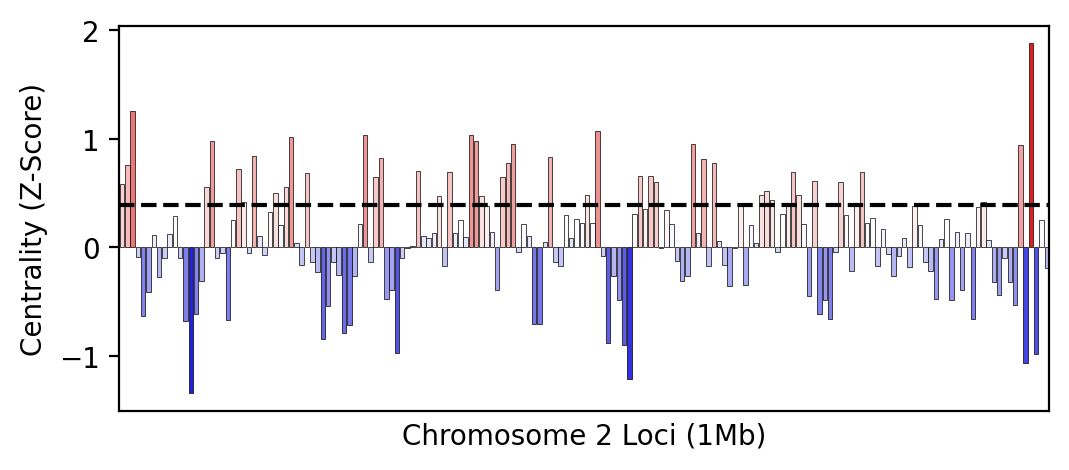

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2.5

sns.barplot(
    data=nodes.head(176), 
    x='local_bin',
    y='zscores',
    dodge=False,
    width=0.85,
    hue='zscores',
    legend=False,
    palette='bwr',
    ec='k',
    lw=0.25,
)

# minimum centrality score for the core
threshold = nodes[nodes['core']]['zscores'].min()
print(f"{threshold=}")

plt.axhline(y=threshold, c='k', ls="--")

plt.ylabel('Centrality (Z-Score)')
plt.xlabel('Chromosome 2 Loci (1Mb)')

plt.xticks([])

# Centrality and clique-expanded eigenvector

'outlier_indices=[99]'
A.shape=(178, 178)
pc_1.shape=(178,) nodes.shape=(178, 6)
Correlation: r=-0.206, (pval=0.00576)


Text(0, 0.5, 'Magnitude')

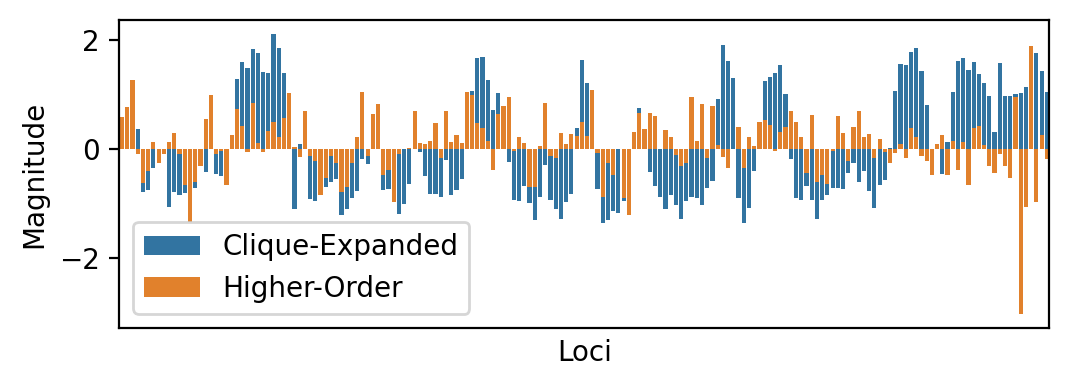

In [9]:
A = matrix.clique_expand_incidence(H, zero_diag=False) 
A = A.sort_index(axis=1)
A = A.sort_index(axis=0)

# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(A, threshold=3)
print(f"'{outlier_indices=}'")

# drop outliers
A = A.drop(outlier_indices, axis=1)
A = A.drop(outlier_indices, axis=0)

A = matrix.normalize_oe(matrix.normalize_kr(A).todense())
A = np.asarray(A)

print(f"{A.shape=}")

pca = PCA(n_components=10)
pca.fit(A)
X_pca = pca.transform(A)
pc_1 = stats.zscore(X_pca[:, 0]) 

print(f"{pc_1.shape=} {nodes.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2

sns.barplot(
    x=range(4, len(X_pca)+4),
    y=pc_1,
    label='Clique-Expanded',
    # alpha=0.6,
)


sns.barplot(
    data=nodes.head(177), 
    x='local_bin',
    y='zscores',
    label='Higher-Order',
)

r, pval = scipy.stats.pearsonr(pc_1, nodes['zscores'].values)
print(f"Correlation: {r=:.3f}, (pval={pval:.5f})")

plt.xticks([])
plt.xlabel('Loci')
plt.ylabel('Magnitude')

# Define the core
### nodes with high centrality

In [10]:
"""
1. Nodes with high centrality
2. Higher-order contacts
3. Non-empty hyperedges (this is hanmdled in the get_core function)
"""
nodes = get_core(H, outlier_indices)
node_idx = nodes[nodes['core'] == True]['local_bin'].values

core = H.copy()
core = core.iloc[node_idx, :]
core = core.loc[:, (core.sum(axis=0) > 2)]

print(f"{core.shape=}")

core.shape=(45, 1194)


Text(0.5, 302.6666666666665, '')

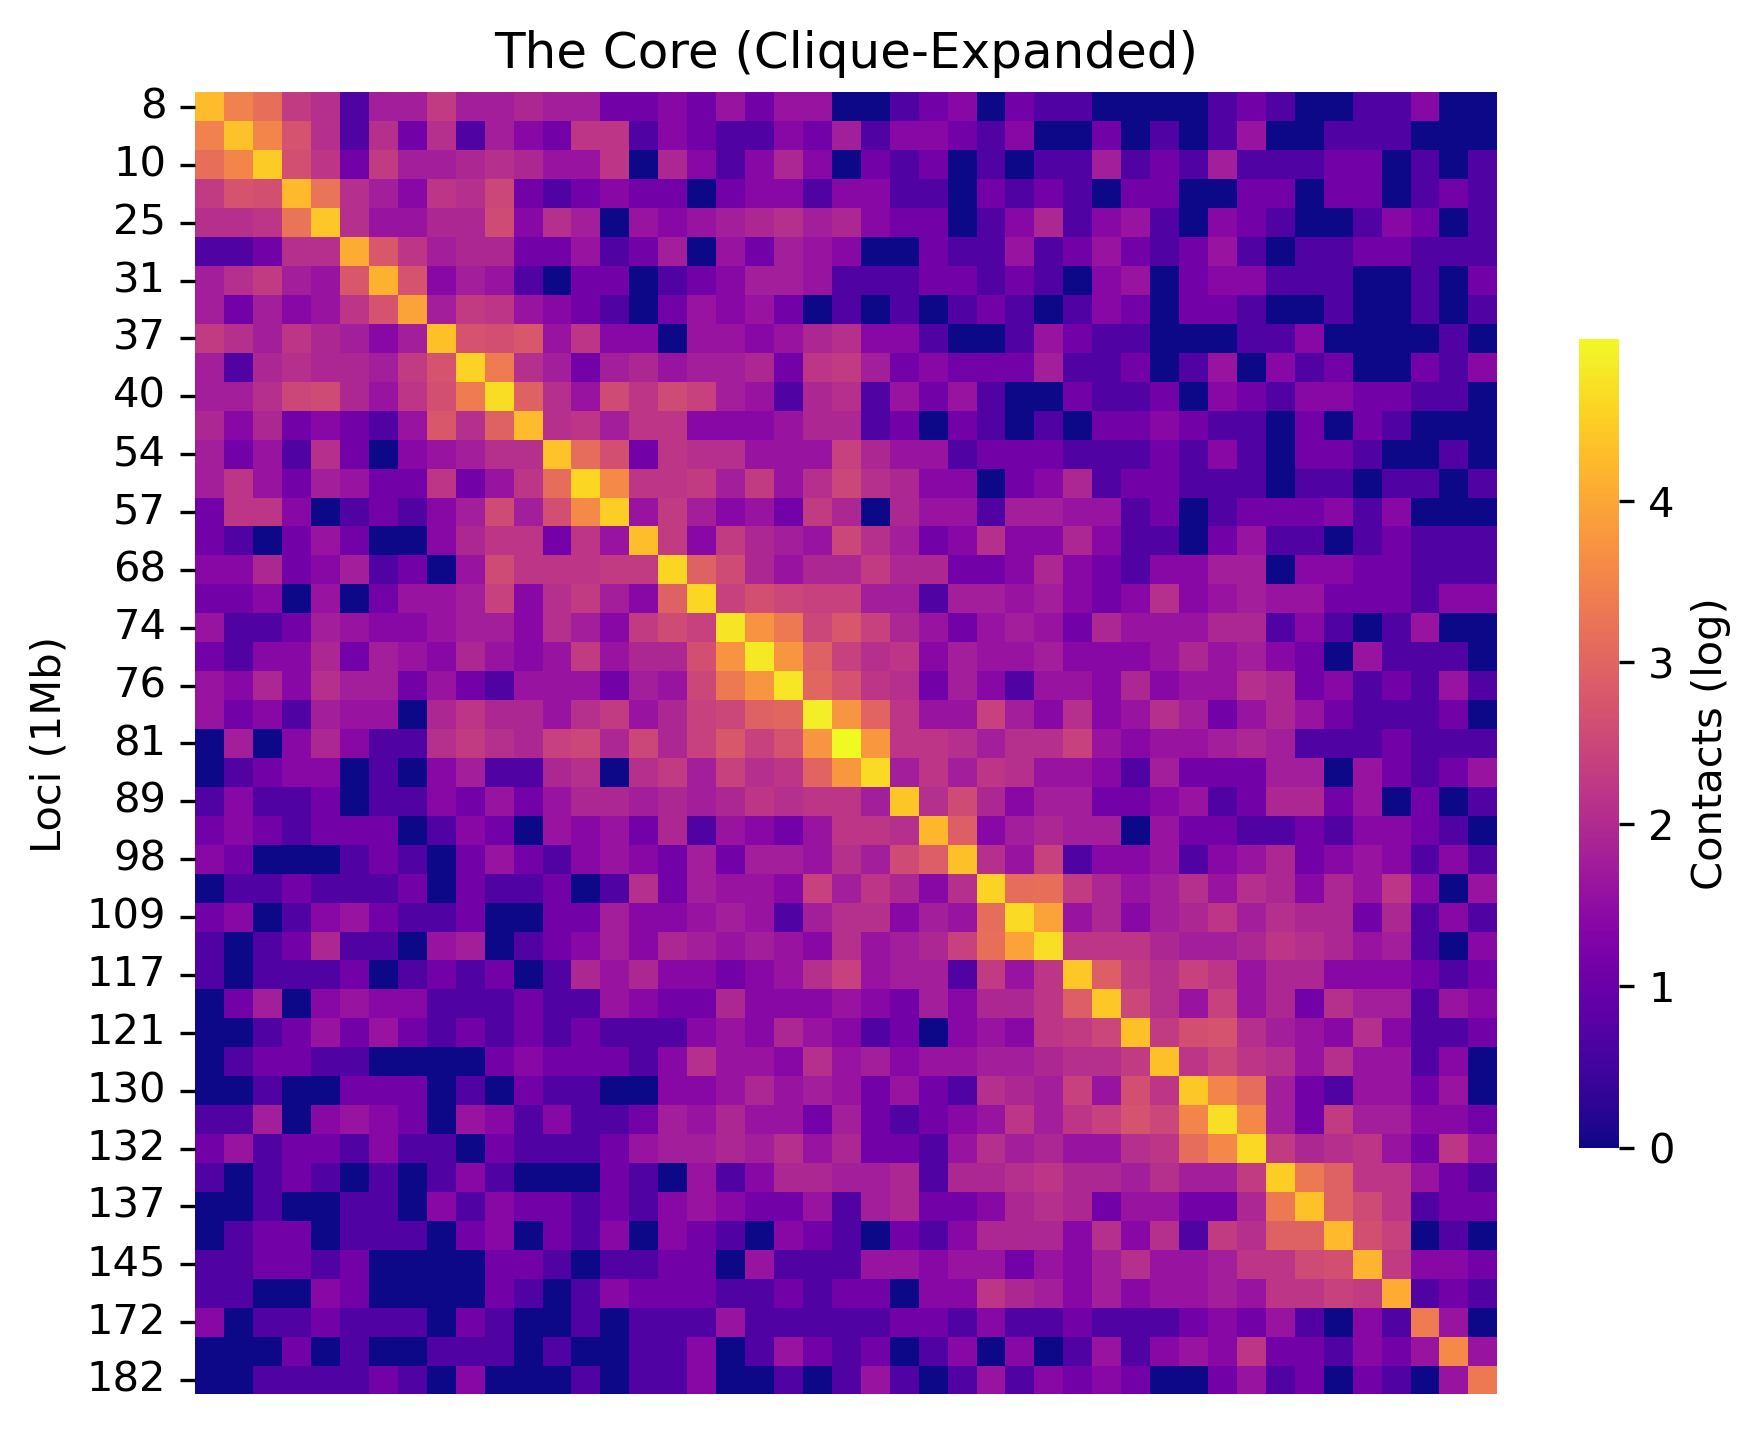

In [11]:
Acore = matrix.clique_expand_incidence(core, zero_diag=False) 
Acore = Acore.sort_index(axis=1)
Acore = Acore.sort_index(axis=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(
    np.log1p(Acore), 
    cmap='plasma',
    square=True, 
    cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
)

# plt.yticks([])
plt.xticks([])

plt.title('The Core (Clique-Expanded)')
plt.ylabel("Loci (1Mb)")
plt.xlabel("")

# plot the incidence matrix

Text(0.5, 1.0, 'Chromosome 2')

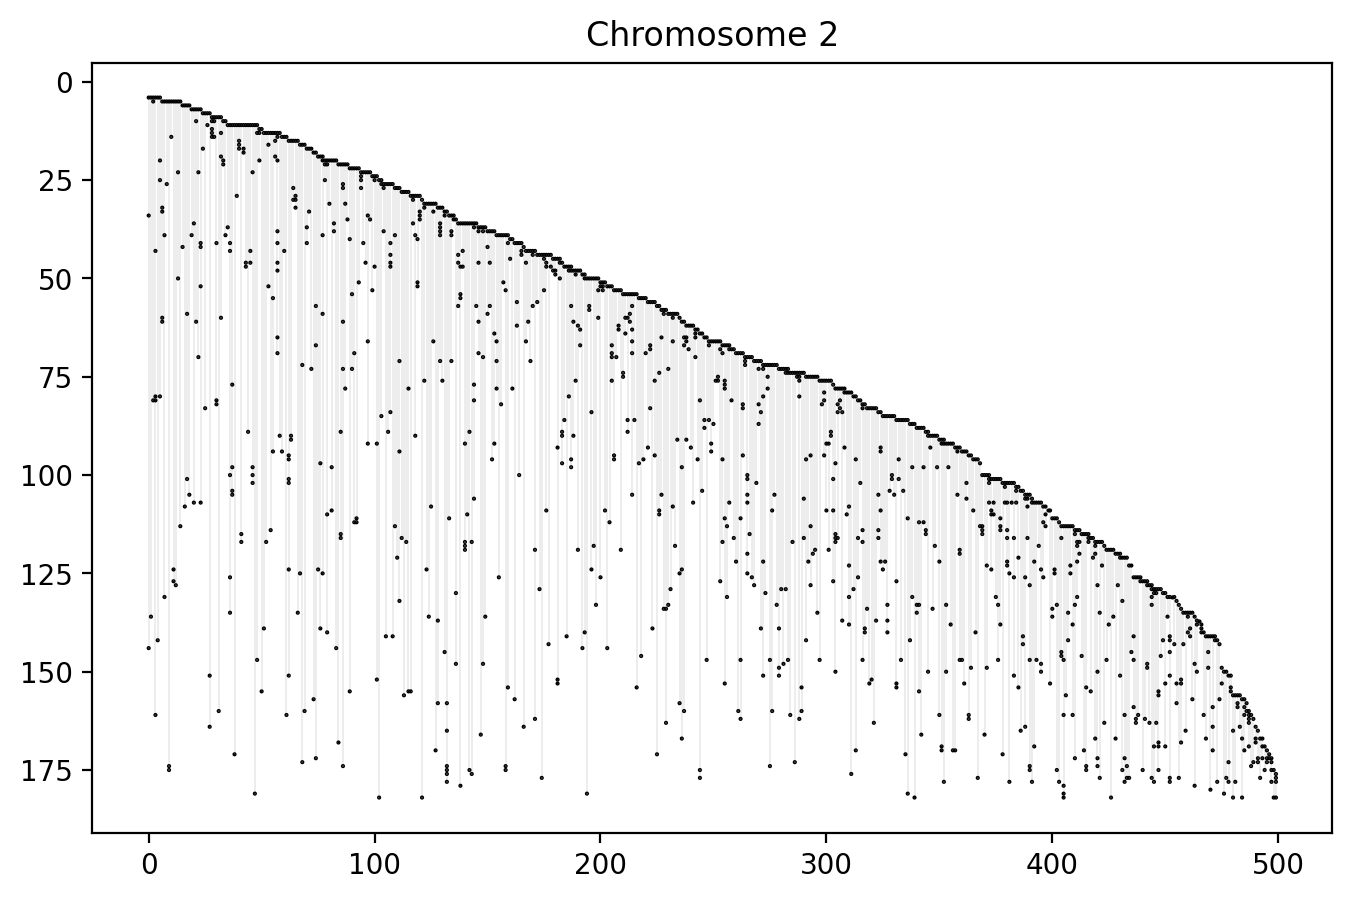

In [12]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(H.drop(outlier_indices).T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"Chromosome {chromosomes[0]}")

Text(0.5, 1.0, 'The Core of Chromosome 2')

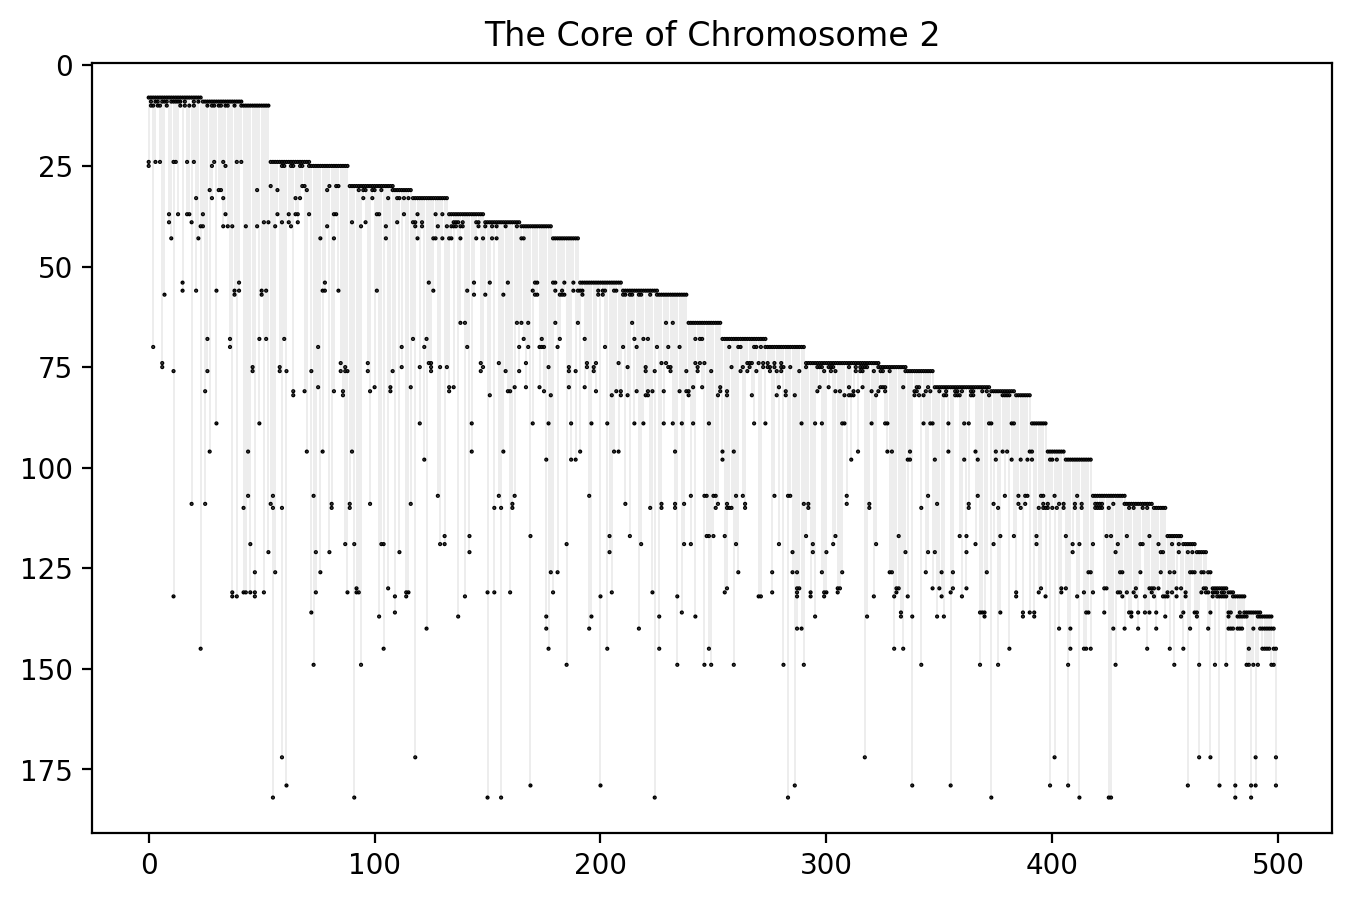

In [13]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(core.T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"The Core of Chromosome {chromosomes[0]}")

In [14]:
# break

# ATAC Seq

In [15]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/4DN_Features/ATACSeq/4DNFIPVAKPXA.bw"

reload(core_utils)
atac = core_utils.load_chromosome_feature(
    fpath, 
    chrom='chr2', 
    resolution=resolution,
)

atac['zscores'] = stats.zscore(atac['value'])

print(f"{atac.shape=}")
atac.head()

atac.shape=(183, 6)


,file_id,local_bin,bin_start,bin_end,value,zscores
0,4DNFIPVAKPXA,0,0.0,1000000.0,0.000000,-2.510492
1,4DNFIPVAKPXA,1,1000000.0,2000000.0,0.000000,-2.510492
2,4DNFIPVAKPXA,2,2000000.0,3000000.0,0.000000,-2.510492
3,4DNFIPVAKPXA,3,3000000.0,4000000.0,565850.943557,0.071366
4,4DNFIPVAKPXA,4,4000000.0,5000000.0,669870.695593,0.545986


pdf.shape=(146, 10)
Correlation: r=0.460, (pval=0.00000)


Text(0, 0.5, 'Magnitude')

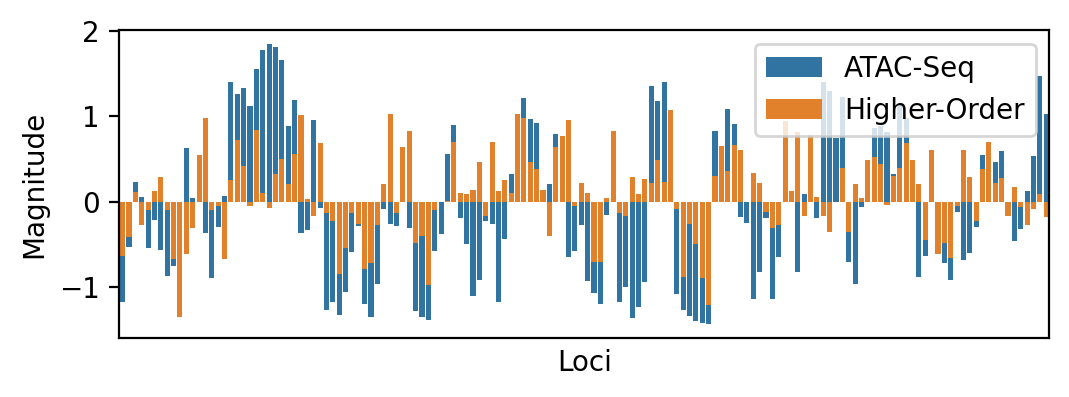

In [16]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2


pdf = nodes.copy()
pdf = pd.merge(
    nodes, atac,
    how='left',
    left_on='local_bin',
    right_on='local_bin',
    suffixes=('_ho', '_atac')
)

start = 4
stop = 150

pdf = pdf.iloc[start:stop]

print(f"{pdf.shape=}")


sns.barplot(
    data=pdf, 
    x='local_bin',
    y='zscores_atac',
    label='ATAC-Seq',
)

sns.barplot(
    data=pdf, 
    x='local_bin',
    y='zscores_ho',
    label='Higher-Order',
)

r, pval = scipy.stats.pearsonr(pdf['zscores_atac'], pdf['zscores_ho'])
print(f"Correlation: {r=:.3f}, (pval={pval:.5f})")

plt.xticks([])
plt.xlabel('Loci')
plt.ylabel('Magnitude')

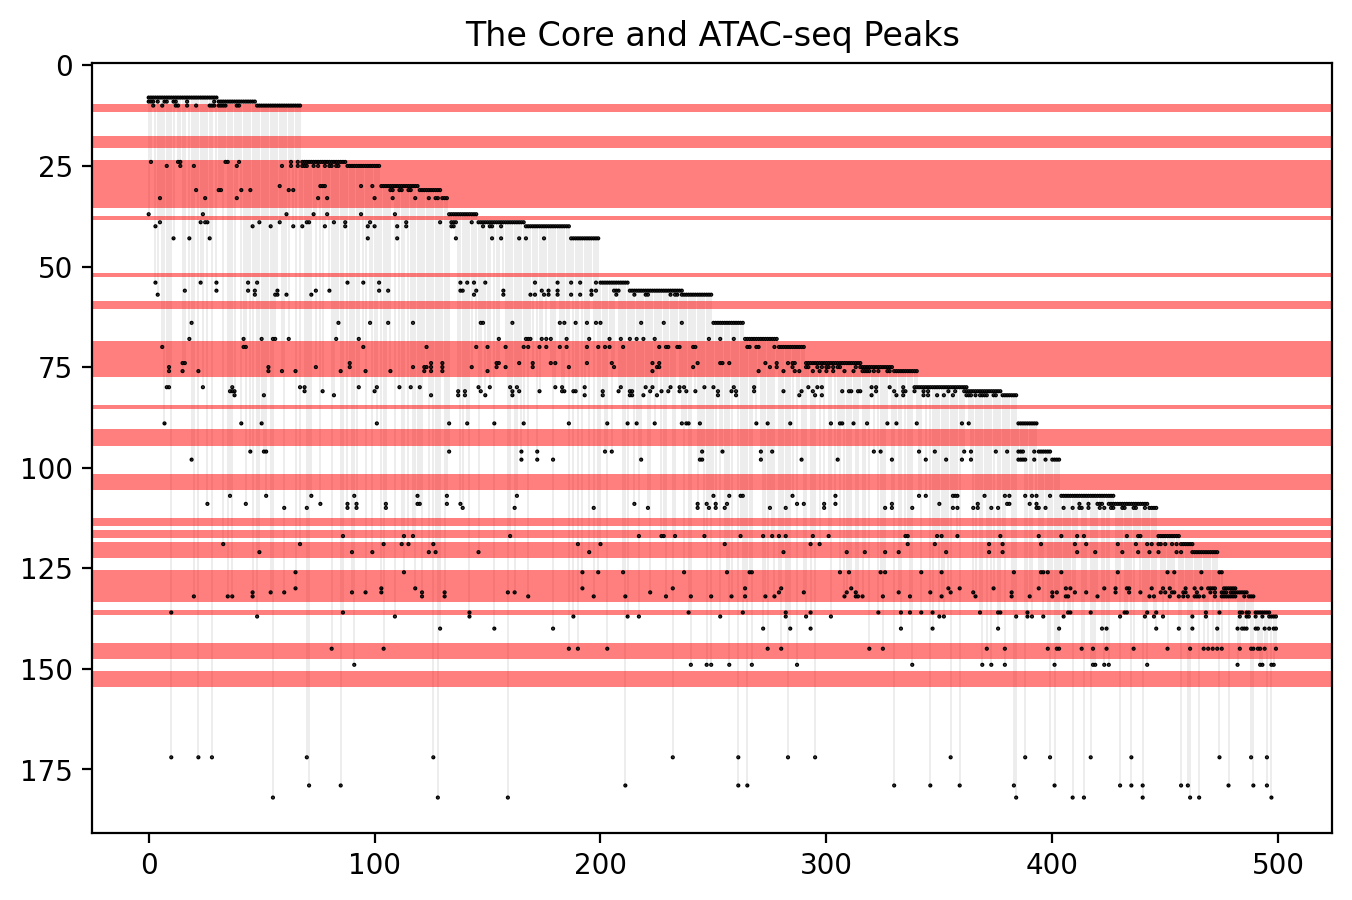

In [17]:

node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(core.T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"The Core and ATAC-seq Peaks")

# plot at the atac seq signal
for idx, row in pdf.iterrows():
    
    if row['zscores_atac'] > 0:
        plt.gca().axhspan(
            row['local_bin'] - 0.5, 
            row['local_bin'] + 0.5,
            facecolor='red', 
            alpha=0.5,
        )


# Load Genes

In [18]:
fpath = "../../resources/genes.parquet"

LOG_EXPRESSION_THRESHOLD = 2

gdf = pd.read_parquet(fpath)
gdf = gdf[gdf['is_gene']]
gdf = gdf[gdf['is_pt_gene']]

gdf = gdf[gdf['Chromosome'].isin(chromosomes)]
gdf['local_bin'] = gdf['midpoint'].apply(lambda x: np.ceil(x // resolution))
gdf['in_core'] = gdf['local_bin'].isin(core.index)

gdf['expressed_above_threshold'] = gdf['expression_log'] > LOG_EXPRESSION_THRESHOLD

print(f"{gdf.shape=}")
gdf.head()

gdf.shape=(1820, 20)


,gene_id,gene_name,gene_source,gene_biotype,Chromosome,Start,End,length,midpoint,is_tf,is_gene,is_pt_gene,is_expressed,expression,expression_log,mESC_panglaoDB_marker,mESC_GO_marker,local_bin,in_core,expressed_above_threshold
3541,ENSMUSG00000032852,RSPO4,ensembl_havana,protein_coding,2,151684846,151716588,31742,151700717,False,True,True,True,0.010000,0.009950,False,False,151.0,False,False
3542,ENSMUSG00000050023,OR5D46,ensembl_havana,protein_coding,2,88167064,88172392,5328,88169728,False,True,True,False,0.000000,0.000000,False,False,88.0,False,False
3543,ENSMUSG00000027304,RTF1,ensembl_havana,protein_coding,2,119505548,119565888,60340,119535718,False,True,True,True,10.145000,2.410991,False,True,119.0,True,True
3544,ENSMUSG00000056995,OR4P7,ensembl_havana,protein_coding,2,88217405,88231143,13738,88224274,False,True,True,False,0.000000,0.000000,False,False,88.0,False,False
3545,ENSMUSG00000027296,ITPKA,ensembl_havana,protein_coding,2,119572817,119581744,8927,119577280,False,True,True,True,19.206667,3.006013,False,False,119.0,True,True


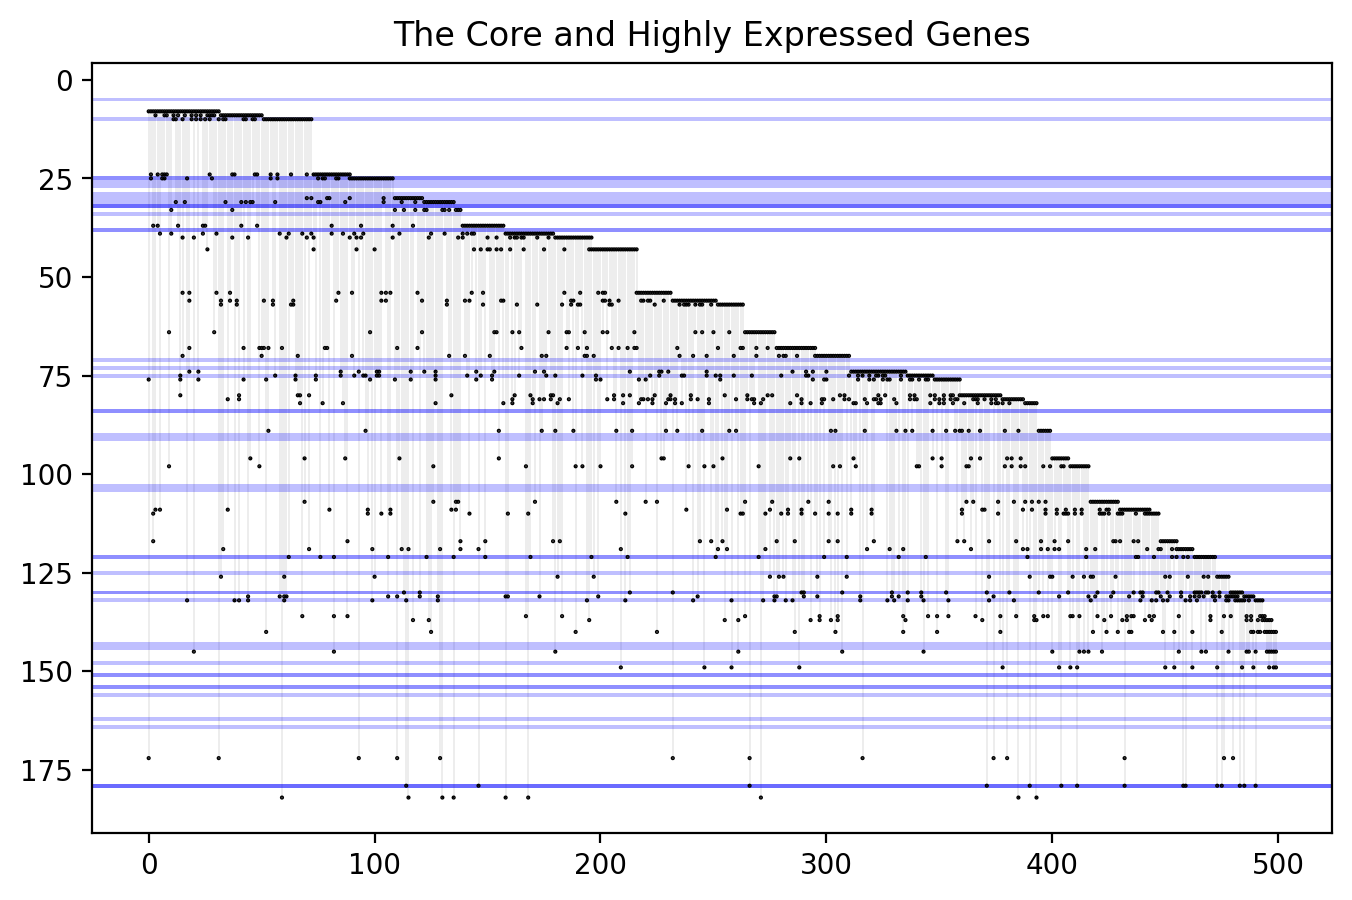

In [19]:
threshold = 75

node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(core.T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"The Core and Highly Expressed Genes")

# plot at the atac seq signal
for idx, row in gdf.iterrows():
    
    if row['expression'] > threshold:

        plt.gca().axhspan(
            row['local_bin'] - 0.5, 
            row['local_bin'] + 0.5,
            facecolor='blue', 
            alpha=0.25,
        )

In [20]:
core_genes = gdf[gdf['in_core'] & gdf['is_expressed']]
print(f"{core_genes.shape=}")

core_genes = core_genes.sort_values(by='expression', ascending=False)
core_genes[[
    'gene_name', 
    'is_tf', 
    'mESC_panglaoDB_marker',
    'mESC_panglaoDB_marker',
]].head(15)

core_genes.shape=(328, 20)


,gene_name,is_tf,mESC_panglaoDB_marker,mESC_panglaoDB_marker
5090,RPS21,False,False,False
4094,HNRNPA3,False,False,False
6200,TUBB4B,False,False,False
4903,NOP56,False,False,False
3939,SERF2,False,False,False
6338,PCNA,False,False,False
6771,SNRPB,False,False,False
4170,ASS1,False,False,False
6812,ATP5F1C,False,False,False
5661,PSMA7,False,False,False


In [21]:
genes_by_bin = gdf.groupby('local_bin').agg(
    n_genes = ('gene_name', 'nunique'),
    expressed_above_threshold = ('expressed_above_threshold', 'sum'),
    n_pangloa = ('mESC_panglaoDB_marker', 'sum'),
    n_go = ('mESC_GO_marker', 'sum'),
    mean_expression = ('expression', 'mean'),
    mean_log_expression = ('expression_log', 'mean'),
).reset_index()

genes_by_bin = pd.merge(genes_by_bin, nodes, 
                       how='left')

genes_by_bin = genes_by_bin.sort_values(by='mean_expression', ascending=False)
genes_by_bin.head(10)

,local_bin,n_genes,expressed_above_threshold,n_pangloa,n_go,mean_expression,mean_log_expression,node_centrality,zscores,node_centrality_norm,core
160,179.0,14,7,0,0,123.975357,2.345370,0.005595,-0.984790,0.777302,False
34,38.0,10,4,1,0,78.982333,2.067679,0.005614,-0.164126,0.841150,False
65,75.0,7,3,0,0,71.257143,1.966347,0.005609,-0.397490,0.822994,False
25,29.0,17,14,0,1,54.133333,2.869918,0.005638,0.844358,0.919611,True
28,32.0,32,19,0,0,46.423958,2.238087,0.005625,0.321787,0.878954,False
63,73.0,9,2,0,0,44.601296,1.703212,0.005627,0.382696,0.883693,False
143,162.0,6,4,0,0,42.226667,2.607385,0.005607,-0.489784,0.815813,False
6,10.0,5,1,0,0,28.384667,1.643455,0.005621,0.114111,0.862797,False
22,26.0,33,16,0,1,28.325303,1.700481,0.005635,0.717077,0.909708,True
62,72.0,4,3,0,0,24.429167,2.893475,0.005629,0.468961,0.890404,True


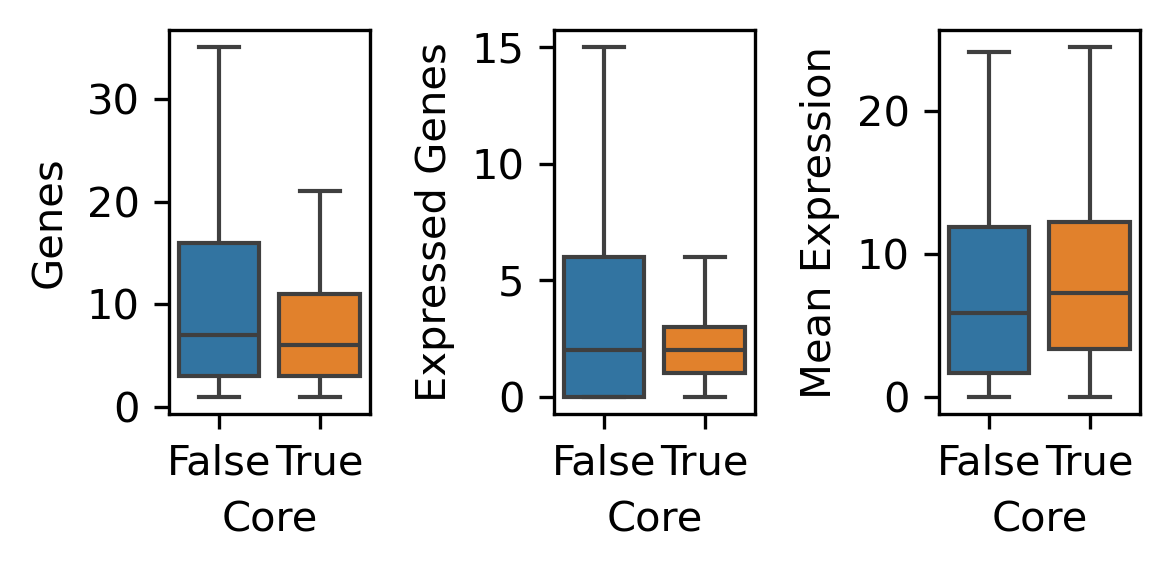

In [22]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

fig, axs = plt.subplots(1, 3)
axs = axs.ravel()

columns = {
    'n_genes' : 'Genes',
    'expressed_above_threshold' : 'Expressed Genes',
    'mean_expression' : 'Mean Expression',
}


for i, (column, label) in enumerate(columns.items()):
    
    sns.boxplot(data=genes_by_bin,
                x='core',
                y=column,
                hue='core',
                showfliers=False,
                ax=axs[i],
                legend=False,
               )
    axs[i].set_xlabel("Core")
    axs[i].set_ylabel(label)
    
plt.tight_layout()

# Load Hi-C

In [23]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/f1219_population_hic/4DNFICF9PA9C.mcool"

chrom = "chr2"
clr = cooler.Cooler(f'{fpath}::resolutions/{1000000}')
Ahic = clr.matrix(balance=False).fetch(str(chrom))[:]
Ahic = np.nan_to_num(Ahic)
print(f"{Ahic.shape=}")

print(f"{Ahic.shape=}")

Ahic = pd.DataFrame(Ahic)
Ahic.head()

Ahic.shape=(183, 183)
Ahic.shape=(183, 183)


,0,1,2,3,4,5,6,7,8,9,...,173,174,175,176,177,178,179,180,181,182
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,77291,5233,1072,872,464,309,421,...,5,11,0,2,4,5,6,9,18,0
4,0,0,0,5233,61320,3961,800,356,208,281,...,8,12,1,0,3,7,3,13,18,0


,local_bin,degree,in_core
0,0,0,False
1,1,0,False
2,2,0,False
3,3,94371,False
4,4,79025,False


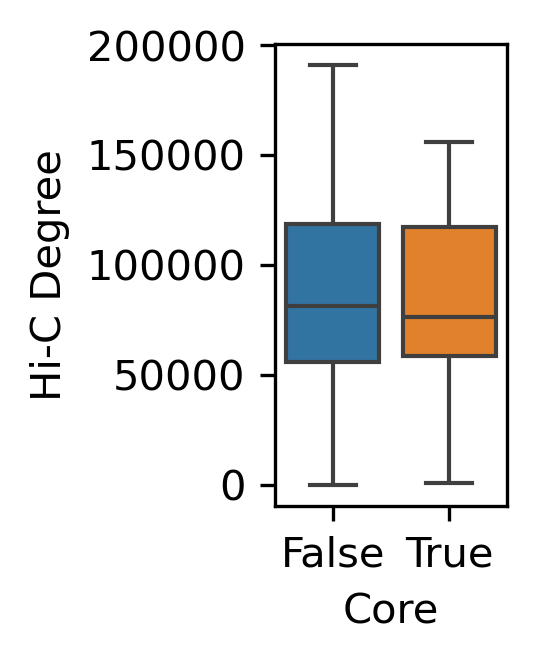

In [24]:
hic = pd.DataFrame({
    'local_bin' : list(range(len(Ahic))),
    'degree' : Ahic.sum(axis=1),
})

hic['in_core'] = hic['local_bin'].isin(core.index)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1, 2
sns.boxplot(
    data=hic,
    x='in_core',
    y='degree',
    hue='in_core',
    showfliers=False,
    legend=False,
)

plt.ylabel("Hi-C Degree")
plt.xlabel("Core")

hic.head()

'outlier_indices=[25, 164]'
Hic_norm.shape=(178, 178)
hic_pc_1.shape=(178,) nodes.shape=(178, 5)
Correlation: r=0.100, (pval=0.18393)


Text(0, 0.5, 'Magnitude')

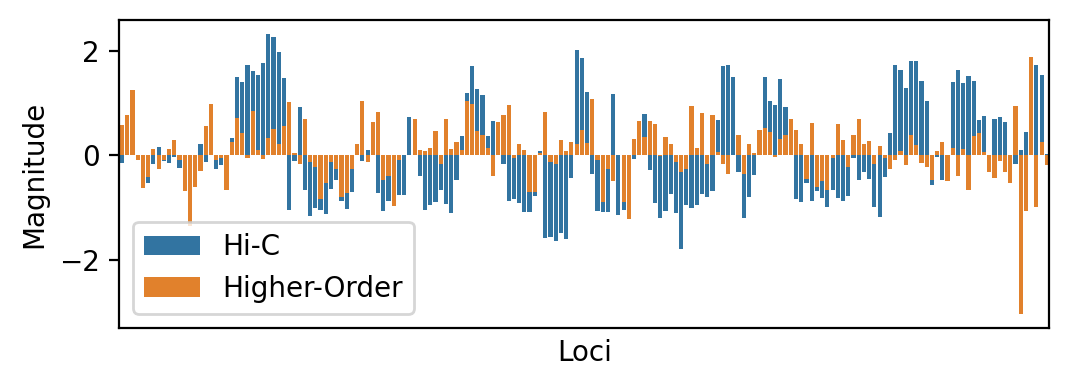

In [25]:
# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(Ahic, threshold=3)
print(f"'{outlier_indices=}'")

# drop outliers
Hic_norm = Ahic.copy()
Hic_norm = Hic_norm.drop(outlier_indices, axis=1)
Hic_norm = Hic_norm.drop(outlier_indices, axis=0)

Hic_norm = matrix.normalize_oe(matrix.normalize_kr(Hic_norm.loc[3:, 3:]).todense())
Hic_norm = np.asarray(Hic_norm)

print(f"{Hic_norm.shape=}")

pca = PCA(n_components=10)
pca.fit(Hic_norm)
X_pca = pca.transform(Hic_norm)
hic_pc_1 = stats.zscore(X_pca[:, 0]) 

print(f"{hic_pc_1.shape=} {nodes.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 2

sns.barplot(
    x=range(4, len(X_pca)+4),
    y=hic_pc_1,
    label='Hi-C',
)

sns.barplot(
    data=nodes.head(177), 
    x='local_bin',
    y='zscores',
    label='Higher-Order',
)

r, pval = scipy.stats.pearsonr(hic_pc_1, nodes['zscores'].values)
print(f"Correlation: {r=:.3f}, (pval={pval:.5f})")

plt.xticks([])
plt.xlabel('Loci')
plt.ylabel('Magnitude')

In [26]:
# compute overlap between bins

hic = pd.DataFrame({
    'local_bin' : range(4, len(hic_pc_1) + 4),
    'hic' : hic_pc_1,
})

hic = pd.merge(
    hic, 
    nodes, 
    how='left',
)

hic['hic_core'] = hic['hic'].values > np.quantile(hic['hic'].values, 0.75)

print(f"{hic.shape=}")

hic[['core', 'hic_core']].value_counts().reset_index()

hic.shape=(178, 7)


,core,hic_core,count
0,False,False,100
1,False,True,32
2,True,False,32
3,True,True,13


In [27]:
# break

# Single-cell

In [28]:
dpath = "/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/"
file_list = glob.glob(f"{dpath}*")
np.random.shuffle(file_list)
file_list[:10]

['/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o2b22.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o1b63.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o1b90.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o1b53.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o2b77.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o2b31.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o2b44.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o3b20.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_table/o4b02.GRCm39.align_table.parquet',
 '/scratch/indikar_root/indikar1/shared_data/single_cell/align_t

In [29]:
reload(core_utils)
sample_size = 379

df_sc = core_utils.load_pore_c(
    file_list[:sample_size], 
    chrom_starts, 
    resolution=resolution, 
    chroms=chromosomes
)

df_sc['ones'] = 1
print(f"{df_sc.shape=}")
df_sc.head()

o2b22 (220, 8)
o1b63 (2116, 8)
o1b90 (170, 8)
o1b53 (57152, 8)
o2b77 (628, 8)
o2b31 (1438, 8)
o2b44 (1916, 8)
o3b20 (5972, 8)
o4b02 (12, 8)
o1b07 (5101, 8)
o3b84 (3670, 8)
o4b31 (432, 8)
o1b34 (2752, 8)
o1b59 (14258, 8)
o2b62 (18, 8)
o3b23 (14463, 8)
o3b67 (10199, 8)
o1b76 (1214, 8)
o3b46 (5730, 8)
o4b72 (7, 8)
o2b74 (600, 8)
o4b93 (8, 8)
o1b18 (58195, 8)
o1b68 (236, 8)
o1b51 (24450, 8)
o2b80 (10, 8)
o1b40 (8529, 8)
o1b45 (47539, 8)
o3b65 (9403, 8)
o1b72 (91222, 8)
o4b12 (5, 8)
o2b91 (3554, 8)
o1b21 (29188, 8)
o3b89 (3826, 8)
o4b01 (8, 8)
o3b21 (4063, 8)
o3b41 (2268, 8)
o4b37 (429, 8)
o2b29 (1459, 8)
o3b54 (5208, 8)
o1b30 (42201, 8)
o4b70 (1048, 8)
o3b56 (8557, 8)
o3b90 (3807, 8)
o3b75 (18335, 8)
o4b78 (1295, 8)
o3b42 (23150, 8)
o1b35 (116, 8)
o1b12 (4681, 8)
o2b13 (653, 8)
o2b54 (45, 8)
o3b83 (6526, 8)
o4b39 (1228, 8)
o2b30 (268, 8)
o3b25 (3225, 8)
o1b44 (303, 8)
o3b63 (23179, 8)
o4b21 (7, 8)
o3b02 (9984, 8)
o3b48 (10179, 8)
o1b46 (39334, 8)
o2b03 (8, 8)
o3b79 (468, 8)
o2b16 (2188, 8)

,read_name,align_id,order,chrom,local_position,global_bin,local_bin,basename,ones
144,01670540-6ada-4303-9f8b-1baffb571d03,6379,2,2,143788526.0,339,144,o2b22,1
149,01670540-6ada-4303-9f8b-1baffb571d03,6384,2,2,98497145.0,294,99,o2b22,1
539,06b814dc-2bf9-4b9e-99e8-7c855feea11b,1865,2,2,117736378.0,313,118,o2b22,1
541,06b814dc-2bf9-4b9e-99e8-7c855feea11b,1867,2,2,98492898.0,294,99,o2b22,1
576,073965b5-3c0b-4a84-ac06-2b0884304d69,15607,2,2,143788526.0,339,144,o2b22,1


In [30]:
"""
Note: we keep the the full set because we may want to
find reads across multiple cells
"""
H_sc_full = ut.incidence_by_pivot(
    df_sc, 
    index='read_name',
    columns='local_bin',
    values='ones',
)
print(f"Total: {H_sc_full.shape=}")
H_sc = H_sc_full.T.drop_duplicates().T
print(f"Unique: {H_sc.shape=}")
H_sc.head()

Total: H_sc_full.shape=(179, 1838607)
Unique: H_sc.shape=(179, 11709)


read_name,00000450-c609-417b-b21e-262221da074a,00000c5a-e3a8-4211-bb87-0909050f8b27,00001014-cc1b-40d0-9bae-73e66f935a63,00002865-9322-4570-aee3-7341cb97280a,00003b78-f795-44ce-9c38-66286fdfe4ad,00003d7d-8888-49b4-a84e-382d6631fe0a_1,00004b03-1917-438a-ad4f-2083f8dc1ce5,00004fde-ec13-468f-ba75-fae3881bae38,00005541-5128-4fcb-aa11-8db06593e3bf,000071df-9baa-553c-bb6d-5a5ba08df790,...,ff965271-3510-4fbb-b770-0fa6492aa2ce,ffa0b877-a62a-4127-bf75-844decaca1c0,ffcd313e-8464-4f92-92a8-422dae62328a,ffd2e2b8-9ca4-5358-9617-658eef471fe3,ffe181b6-a694-41fd-aefc-06f6bc217fe9,ffe7f88e-b2e2-434d-9b72-ab5d11bf361b,ffec7d43-80c7-42e3-92c8-083242eff2ef,ffed71dc-f6ea-4384-9d20-6a3298cbc950,ffef7925-994c-5f6f-8792-3469647038e7,fff8bb95-88bf-4fc5-93f7-bbd16428a028_1
local_bin,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'outlier_indices=[99]'
A_sc.shape=(178, 178)


Text(0.5, 302.6666666666665, '')

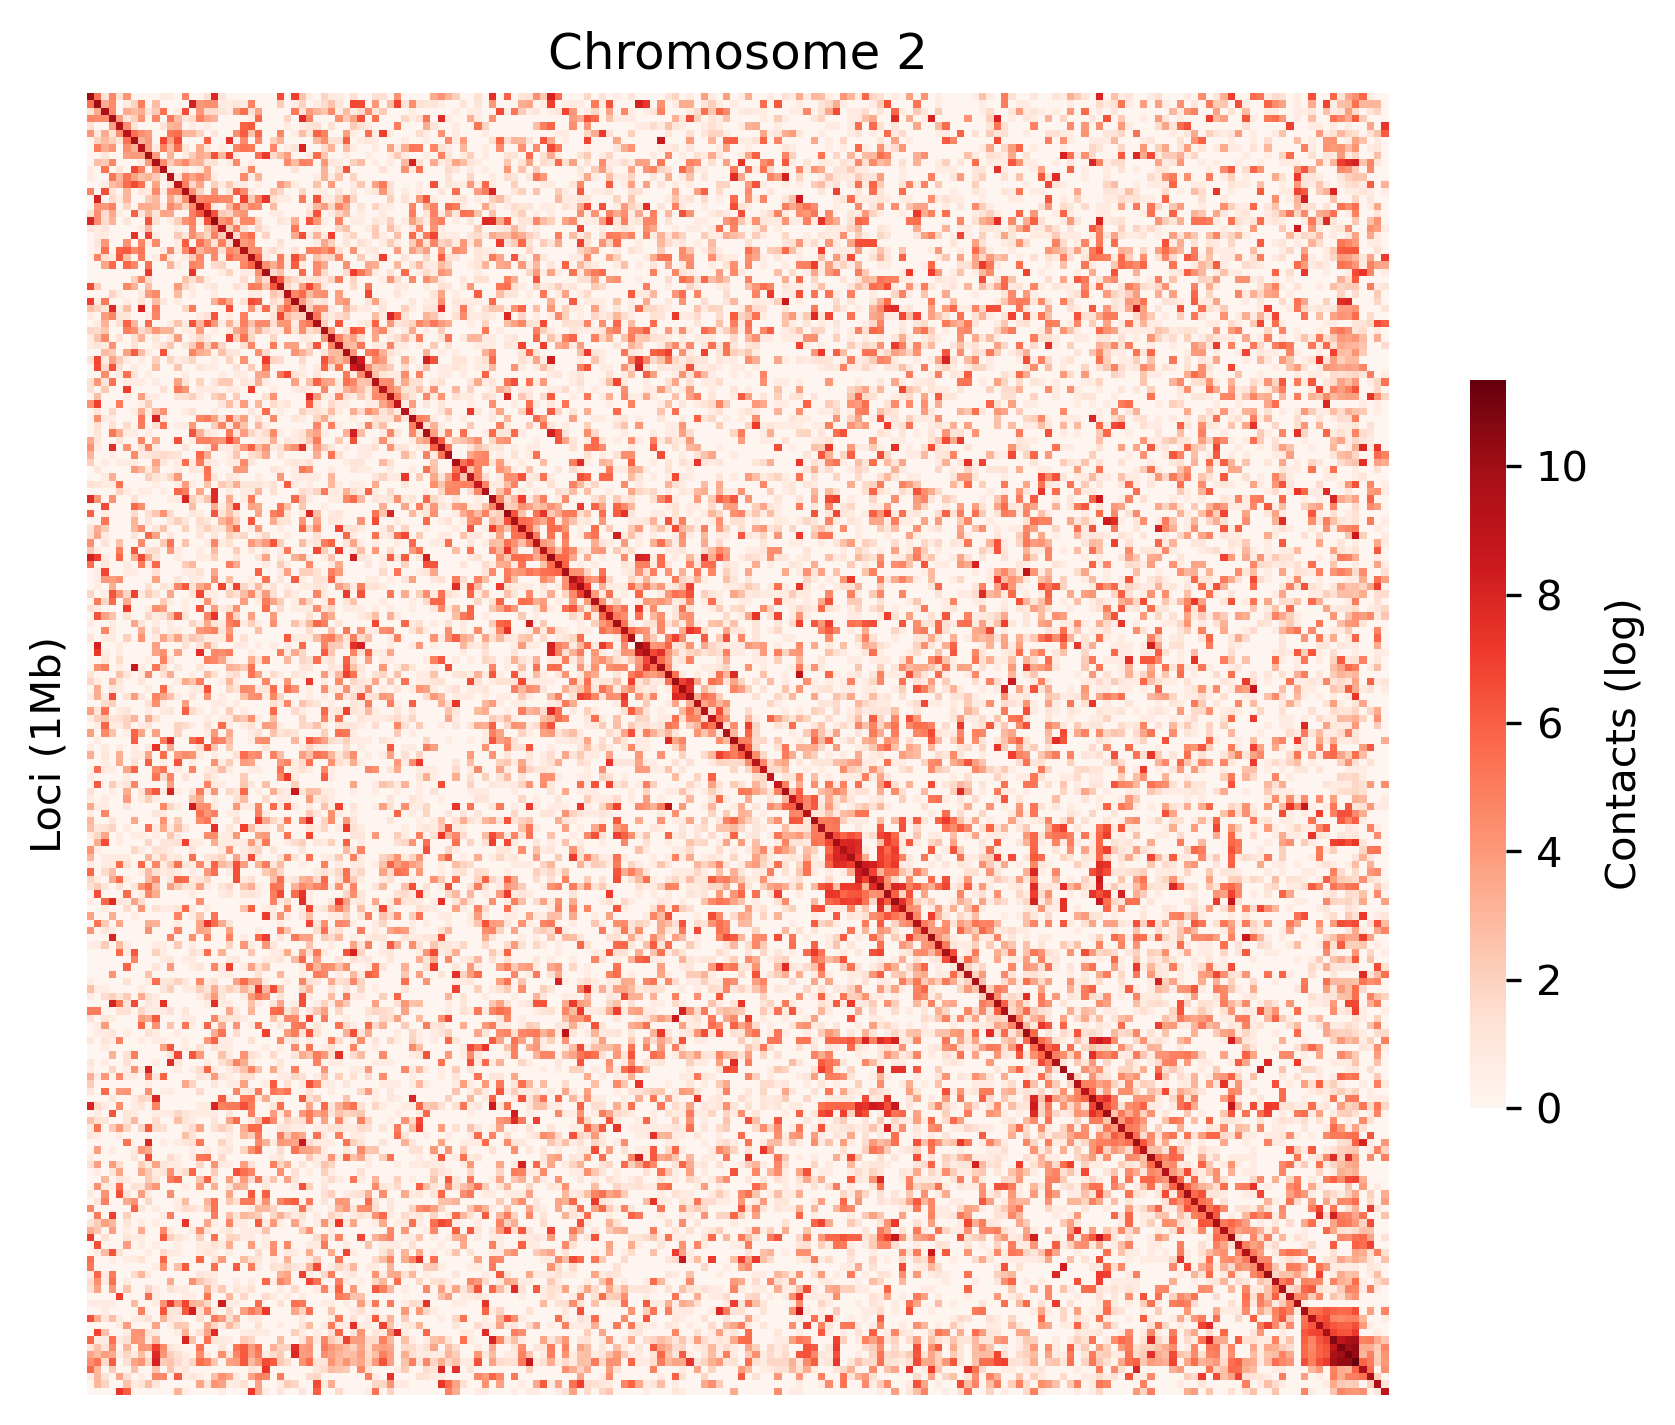

In [31]:
A_sc = matrix.clique_expand_incidence(H_sc_full, zero_diag=False) 
A_sc = A_sc.sort_index(axis=1)
A_sc = A_sc.sort_index(axis=0)

# find and report repeat regions
outlier_indices = matrix.find_outlier_row_indices(A_sc, threshold=1.5)
print(f"'{outlier_indices=}'")

# drop outliers
A_sc = A_sc.drop(outlier_indices, axis=1)
A_sc = A_sc.drop(outlier_indices, axis=0)

print(f"{A_sc.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 7

sns.heatmap(np.log1p(A_sc), 
            cmap='Reds',
            square=True, 
            cbar_kws={'shrink' : 0.45, 'label' : 'Contacts (log)'},
           )

plt.yticks([])
plt.xticks([])

plt.title(f"Chromosome {chromosomes[0]}")
plt.ylabel(f"Loci (1Mb)")
plt.xlabel("")

Text(0.5, 302.6666666666665, '')

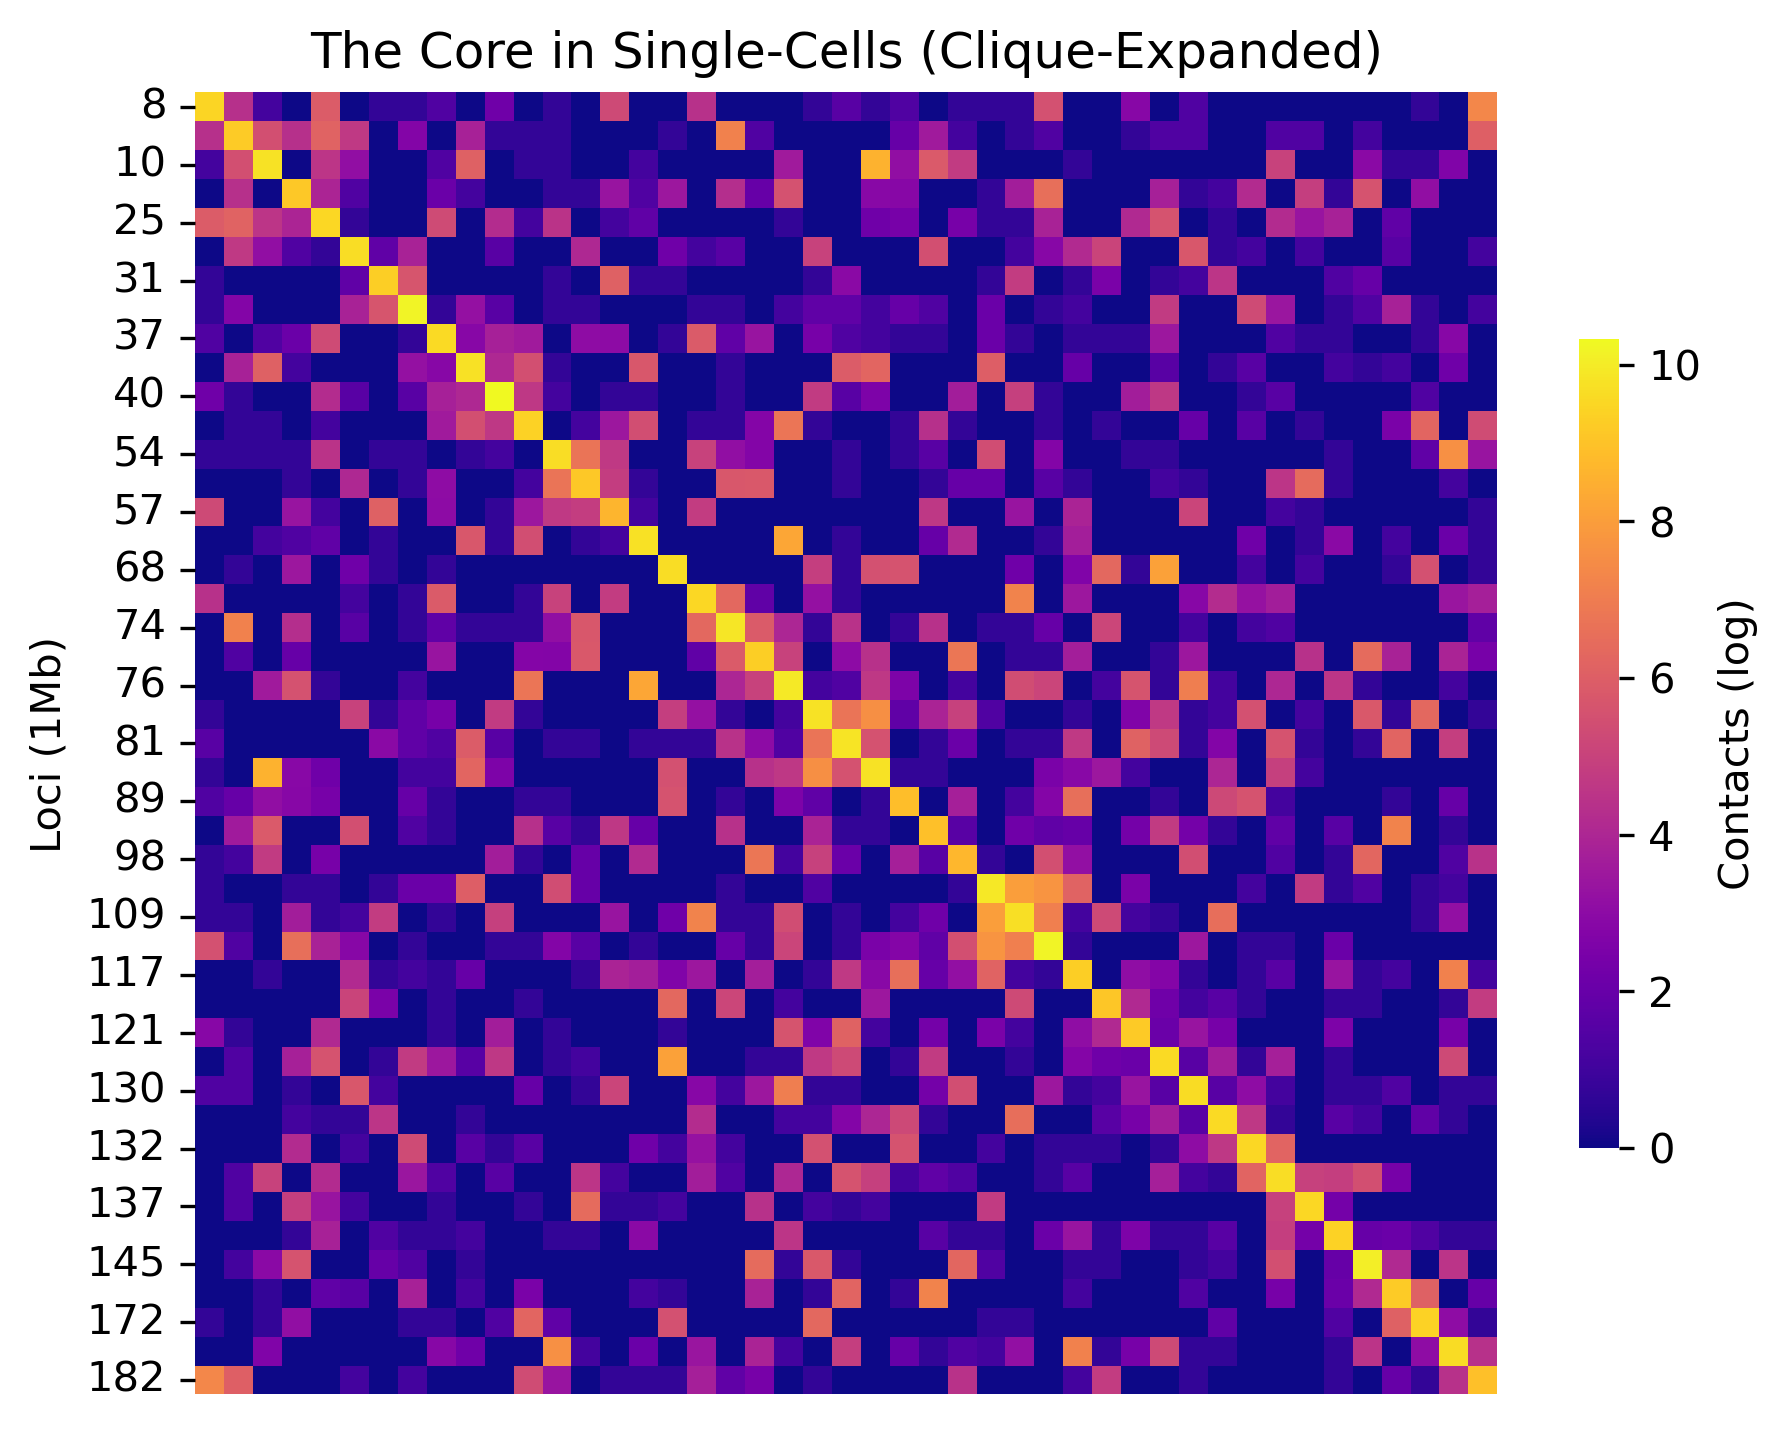

In [32]:
core_of_A_sc = A_sc.copy()

sns.heatmap(
    np.log1p(core_of_A_sc.loc[core.index, core.index]), 
    cmap='plasma',
    square=True, 
    cbar_kws={'shrink' : 0.5, 'label' : 'Contacts (log)'},
)

# plt.yticks([])
plt.xticks([])

plt.title('The Core in Single-Cells (Clique-Expanded)')
plt.ylabel("Loci (1Mb)")
plt.xlabel("")

core_sc.shape=(45, 832)


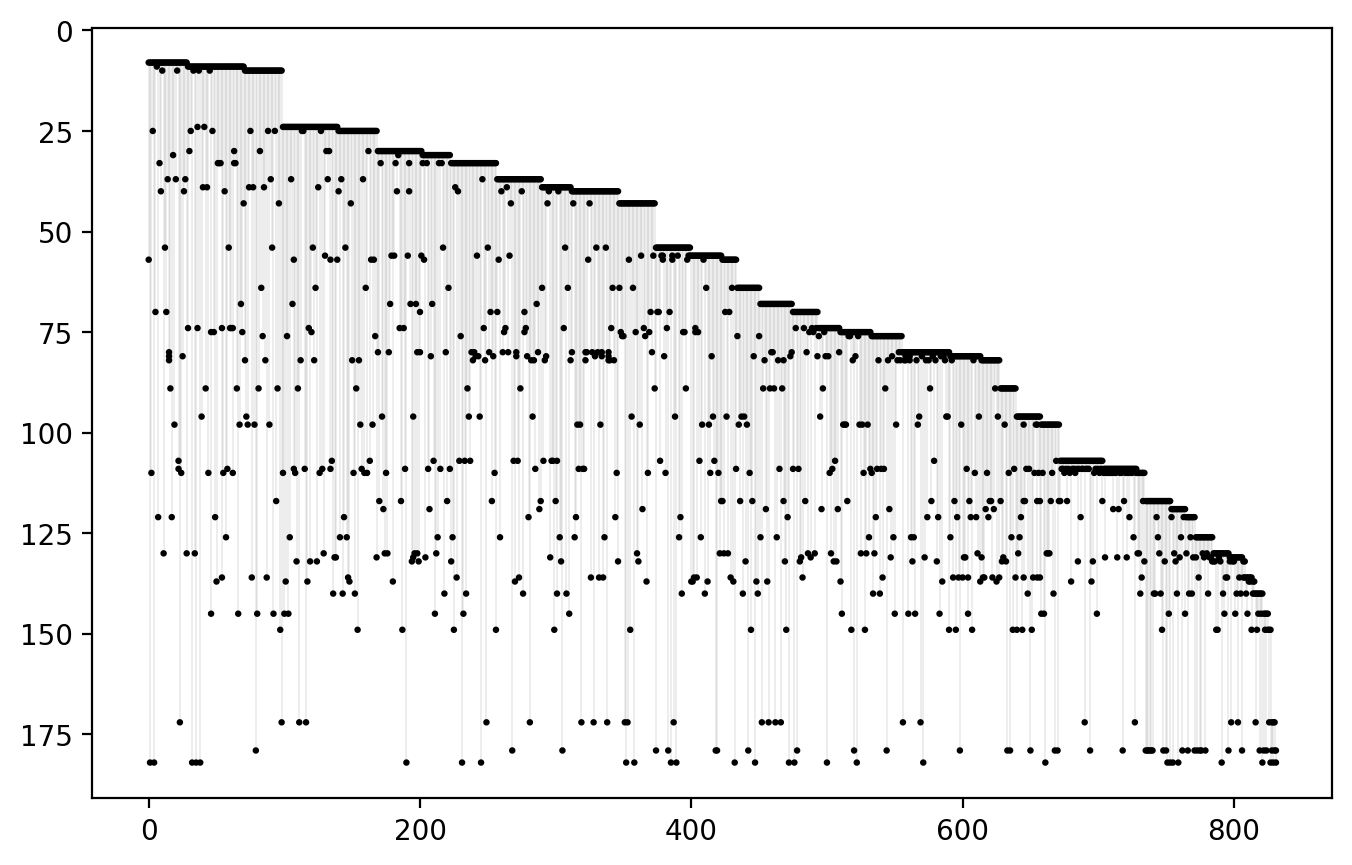

In [33]:
# scpore-c core

core_sc = H_sc.copy()
core_sc = core_sc.loc[core.index]
core_sc = core_sc.loc[:, (core_sc.sum(axis=0) > 1)]
print(f"{core_sc.shape=}")

node_params = {
    's' : 7,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

plt2.plot_incidence(
    ut.sort_by_lowest_index(core_sc), 
    node_color='k',
    node_params=node_params,
    line_params=line_params
)

# plt.title("Core Nodes in Single-Cells")

# # plot at the atac seq signal
# for idx, row in pdf.iterrows():
    
#     if row['zscores_atac'] > 0:
#         plt.gca().axhspan(
#             row['local_bin'] - 0.5, 
#             row['local_bin'] + 0.5,
#             facecolor='red', 
#             alpha=0.5,
#         )


In [34]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
print(f"{core.shape=}")
print(f"{H_sc.shape=}")

core_hyperedges = ut.incidence_to_list_of_list(core)
core_hyperedges = [sorted(x) for x in core_hyperedges]

sc_hyperedges = ut.incidence_to_list_of_list(H_sc)
sc_hyperedges = [sorted(x) for x in sc_hyperedges]


def jaccard_similarity_matrix(list1, list2):
    """
    Computes the Jaccard similarity matrix between two lists of lists.

    Args:
        list1: The first list of lists.
        list2: The second list of lists.

    Returns:
        A NumPy array where each element (i, j) is the Jaccard similarity 
        between the i-th set in list1 and the j-th set in list2.
    """

    # Convert to sets for efficient operations
    list1 = [set(l) for l in list1]
    list2 = [set(l) for l in list2]

    # Create arrays for efficient computation
    intersection_sizes = np.empty((len(list1), len(list2)))
    union_sizes = np.empty((len(list1), len(list2)))

    for i, set1 in enumerate(list1):
        for j, set2 in enumerate(list2):
            intersection_sizes[i, j] = len(set1 & set2)
            union_sizes[i, j] = len(set1 | set2)

    # Handle potential division by zero (empty sets)
    with np.errstate(divide='ignore', invalid='ignore'):
        jaccard_matrix = np.where(
            union_sizes == 0, 0, intersection_sizes / union_sizes
        )
    # Convert to float64 for numerical stability
    jaccard_matrix = jaccard_matrix.astype('float64')

    return jaccard_matrix


jsm = jaccard_similarity_matrix(sc_hyperedges, core_hyperedges)
jsm = pd.DataFrame(
    jsm,
    index=H_sc.columns,
    columns=core.columns,
)
print(f"{jsm.shape=}")
jsm.head()

In [ ]:
# drop scpore-c reads with no similarity to the core

print(f"Total scPore-C Concatemers: {len(jsm)}")
potential_core = jsm[jsm.sum(axis=1) > 0]
print(f"Potential scPore-C Core Concatemers: {len(potential_core)}")
print()

for sc_read, vector in potential_core.head(10).iterrows():
    
    core_idx = np.argmax(vector)
    print(core_idx)
    
    core_read = potential_core.columns[core_idx]
    
    print(sc_read)
    print(core_read)
    
    break
    
#     print(f"\n{similarity=:.3f}")
#     print("core: ", list(core[core_read][core[core_read] > 0].index))
#     print("sc: ", list(H_sc[sc_read][H_sc[sc_read] > 0].index))
    



In [ ]:
df_sc[df_sc['read_name'] == sc_read]


In [ ]:
df[df['read_name'] == core_read]

In [ ]:
break

In [ ]:
jsm.max(axis=1)

In [ ]:
H_sc.head()

In [ ]:
sns.clustermap(jsm)

In [ ]:
break

In [ ]:
node_params = {
    's' : 1,
    'ec' : 'k',
    'lw' : 1,
    'marker' : ".",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.1,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

sample_size = 500
plt2.plot_incidence(ut.sort_by_lowest_index(H_sc.drop(outlier_indices).T.sample(sample_size).T), 
                    node_color='k',
                    node_params=node_params,
                    line_params=line_params)

plt.title(f"Chromosome {chromosomes[0]}")

In [ ]:
break

In [ ]:
break

In [ ]:
break

# choose core by gene expression and fiedler value

In [ ]:
res = []

for expression_threshold in sorted(genes_by_bin['mean_expression'].unique()):
    tmp = genes_by_bin[genes_by_bin['mean_expression'] >= expression_threshold]
    node_idx = tmp['local_bin'].astype(int).values
    node_idx = node_idx[node_idx > 35]

    core = H.loc[node_idx]

    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None
        
    row = {
        'expression_threshold' : expression_threshold,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res = res.sort_values(by='expression_threshold', ascending=False)
res.head(10)

# Maximize the Fiedler Value

In [ ]:
"""choosing from node centralities only"""

res = []

for n_t in nodes['node_centrality_norm'].values:
    
    node_idx = sorted(nodes[nodes['node_centrality_norm'] >= n_t]['local_bin'].values)
    core = H.loc[node_idx]

    # remove non-existant edges
    core = core.loc[:, (core.sum(axis=0) != 0)]

    if core.empty:
        continue
        
    try:
        L = matrix.normalized_hypergraph_laplacian(core).todense()        
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        fiedler_number = eigenvalues[1]
    except:
        fiedler_number = None

    row = {
        'node_thresh' : n_t,
        'n_nodes' : len(node_idx),
        'core_nodes' : node_idx,
        'fiedler_number' : fiedler_number,
    }
    res.append(row)
    
res = pd.DataFrame(res)
res = res.sort_values(by='fiedler_number', ascending=False)
res.head(10)